In [ ]:
!pip install burr

# Traces/Spans

This walks through the traces/spans example. You can see the code in [application.py](application.py).

To ground this, you can see an example action implementation (from `application.py`):

In [5]:
from burr.core import action, State
from burr.visibility import TracerFactory

from typing import Tuple

@action(reads=["prompt"], writes=["mode"])
def choose_mode(state: State, __tracer: TracerFactory) -> Tuple[dict, State]:
    with __tracer("generate_prompt"):
        prompt = (
            f"You are a chatbot. You've been prompted this: {state['prompt']}. "
            f"You have the capability of responding in the following modes: {', '.join(MODES)}. "
            "Please respond with *only* a single word representing the mode that most accurately "
            "corresponds to the prompt. Fr instance, if the prompt is 'draw a picture of a cat', "
            "the mode would be 'generate_image'. If the prompt is 'what is the capital of France', the mode would be 'answer_question'."
            "If none of these modes apply, please respond with 'unknown'."
        )
    with __tracer("query_openai", span_dependencies=["generate_prompt"]):
        with __tracer("create_openai_client"):
            client = _get_openai_client()
        with __tracer("query_openai"):
            result = client.chat.completions.create(
                model="gpt-4",
                messages=[
                    {"role": "system", "content": "You are a helpful assistant"},
                    {"role": "user", "content": prompt},
                ],
            )
    with __tracer("process_openai_response", span_dependencies=["query_openai"]):
        content = result.choices[0].message.content
        mode = content.lower()
        if mode not in MODES:
            mode = "unknown"
        result = {"mode": mode}
    return result, state.update(**result)

# Running the code

The following runs the application on a simple prompt.

In [2]:
from application import application as tracing_and_spans_application

In [3]:
app = tracing_and_spans_application()

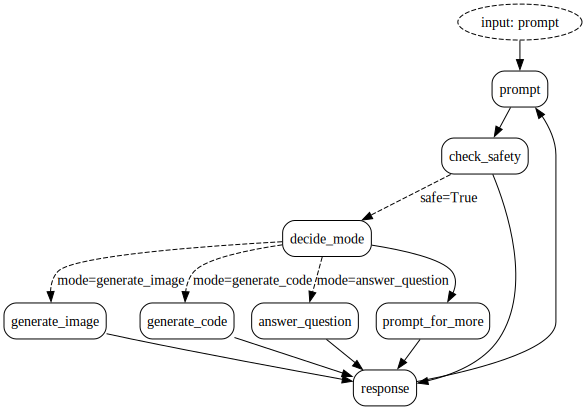

In [5]:
app.visualize(include_conditions=True)

In [7]:
import pprint

action, result, state = app.run(halt_after=["response"], inputs={"prompt" : "please write a haiku"})
pprint.pprint(result)

{'chat_item': {'content': 'Silent stars above,\n'
                          'Whispers of the gentle breeze,\n'
                          'Peaceful dreams unfold.',
               'role': 'assistant',
               'type': 'text'}}


# Viewing in UI

The following cell gives you a link to the prior run in the UI. If you have not yet, run `burr` in your terminal to start the local tracking server.

In [9]:
from IPython.display import Markdown
url = f"[Link to UI](http://localhost:7241/project/demo:tracing/{app.uid})"
Markdown(url)

[Link to UI](http://localhost:7241/project/demo:tracing/d50acb12-080d-499c-b1d5-719862b8ae58)